<a href="https://colab.research.google.com/github/gk222111/CrimeDetection_1/blob/main/CD(DenseNet121%2Bfreez%2Bgelu).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --upgrade

In [ ]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/odins0n/ucf-crime-dataset?select=Train'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gk2211ganesh
Your Kaggle Key: ··········


100%|██████████| 11.0G/11.0G [01:06<00:00, 177MB/s]


In [ ]:
import os
import shutil
import random
from collections import defaultdict

def reduce_images_stratified_percentage(folder_path, percentage):
    # Get a list of all subdirectories (class folders) in the main folder
    subdirectories = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

    # Create a new folder to store the reduced images
    reduced_folder = folder_path + '_reduced'
    if not os.path.exists(reduced_folder):
        os.makedirs(reduced_folder)

    for subdirectory in subdirectories:
        subfolder_path = os.path.join(folder_path, subdirectory)

        # Get a list of all image file names in the current subfolder
        image_files = [f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))]

        # Calculate the number of samples based on the percentage for the current subfolder
        num_samples = int(len(image_files) * percentage)

        # Randomly sample 'num_samples' images from the current subfolder
        selected_images = random.sample(image_files, num_samples)

        # Create a subfolder in the reduced folder for the current class
        reduced_subfolder = os.path.join(reduced_folder, subdirectory)
        if not os.path.exists(reduced_subfolder):
            os.makedirs(reduced_subfolder)

        # Copy the selected images to the reduced subfolder
        for image in selected_images:
            src_path = os.path.join(subfolder_path, image)
            dst_path = os.path.join(reduced_subfolder, image)
            shutil.copy(src_path, dst_path)

In [ ]:
# Example usage:
train_folder_path = '/content/ucf-crime-dataset/Train'  # Replace this with the path to your "train" folder
test_folder_path = '/content/ucf-crime-dataset/Test'  # Replace this with the path to your "test" folder
percentage = 0.15  # 85% reduction (as calculated earlier)

# Reduce images in the train folder
reduce_images_stratified_percentage(train_folder_path, percentage)

# Reduce images in the test folder
reduce_images_stratified_percentage(test_folder_path, percentage)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.applications import DenseNet121
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D , Conv2D,Flatten
from tensorflow.keras.models import Sequential

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report


from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import pickle
from tqdm import tqdm
import numpy as np
import random

# Load the training and test data
train_reduced_path = '/content/ucf-crime-dataset/Train_reduced'
test_reduced_path = '/content/ucf-crime-dataset/Test_reduced'

# Define the categories and labels
categories_labels = {'Abuse':0, 'Arrest':1, 'Arson':2, 'Assualt':3, 'Burglary':4, 'Explosion':5, 'Fighting':6, 'NormalVideos':7, 'RoadAccidents':8, 'Robbery':9, 'Shooting':10, 'Shoplifting':11, 'Stealing':12, 'Vandalism':13}

def load_data(base_dir, categories_labels):
    data = []

    # Go through each category
    for category, label in categories_labels.items():
        # The path to the category directory
        category_dir = os.path.join(base_dir, category)

        # Make sure the directory exists
        if os.path.isdir(category_dir):
            # Go through each file in the directory
            for filename in tqdm(os.listdir(category_dir), desc=f"Loading {category}"):
                # Make sure the file is an image
                if filename.endswith(".jpg") or filename.endswith(".png"):
                    # The path to the image
                    image_path = os.path.join(category_dir, filename)

                    try:
                        # Load the image
                        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                        # Resize the image
                        image = cv2.resize(image, (50, 50))

                        # Reshape the image to 4D array (ImageDataGenerator requires 4D array)
                        image = image.reshape((1,) + image.shape + (1,))

                        # Add the image and its label to the data
                        data.append([image, label])
                    except Exception as e:
                        print(f"Error loading image {image_path}: {e}")

    return data

# Load the training and test data
training_data = load_data(train_reduced_path, categories_labels)
test_data = load_data(test_reduced_path, categories_labels)

# Combine the training and test data
total_data = training_data + test_data

print(f"Loaded {len(total_data)} images.")

Loading Vandalism: 100%|██████████| 166/166 [00:00<00:00, 3330.25it/s]

Loaded 204681 images.


In [ ]:
# Load the training and test data
train_reduced_path = '/content/ucf-crime-dataset/Train_reduced'
test_reduced_path = '/content/ucf-crime-dataset/Test_reduced'

In [ ]:
crime_types=os.listdir(train_reduced_path)
n=len(crime_types)
print("Number of Crime categories : ",n)

Number of Crime categories :  14


In [ ]:
crimes={}
train=test=0
for clss in crime_types:
    num=len(os.listdir(os.path.join(train_reduced_path,clss)))
    train+=num
    test+=len(os.listdir(os.path.join(test_reduced_path,clss)))

    crimes[clss]=num

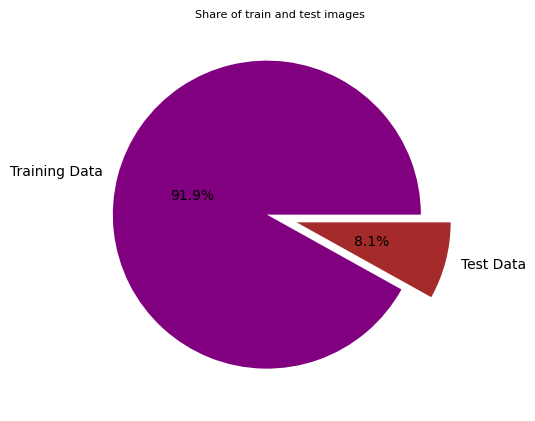

In [ ]:
colors= ['purple', 'brown']
plt.figure(figsize=(10, 5))
plt.pie(x=np.array([train,test]), autopct="%.1f%%", explode=[0.1, 0.1], labels=["Training Data", "Test Data"], pctdistance=0.5, colors=colors)
plt.title("Share of train and test images ", fontsize=8);

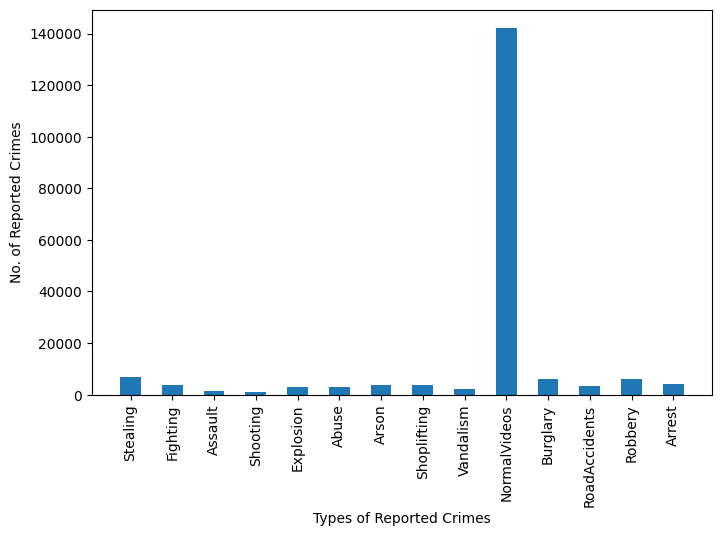

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(list(crimes.keys()), list(crimes.values()), width=0.5,align="center")
plt.xticks(rotation=90)

plt.xlabel("Types of Reported Crimes")
plt.ylabel("No. of Reported Crimes")
plt.show()

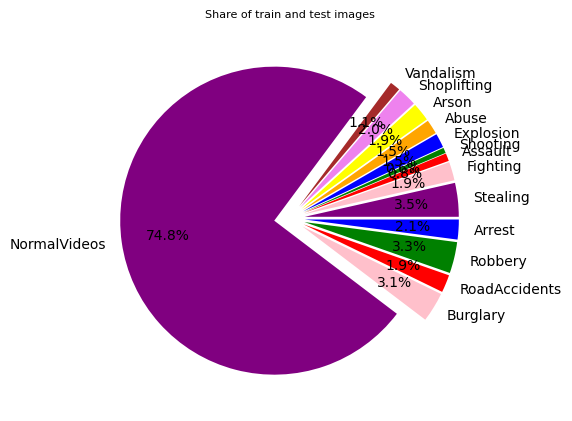

In [ ]:
colors = ['purple', 'pink','red', 'green', 'blue', 'orange', 'yellow', 'violet', 'brown']

# Create the pie chart with the specified colors
plt.figure(figsize=(10, 5))
plt.pie(x=np.array(list(crimes.values())), autopct="%.1f%%", explode=[0.1] * n, labels=list(crimes.keys()), pctdistance=0.7, colors=colors)
plt.title("Share of train and test images", fontsize=8)

# Show the plot
plt.show()

In [ ]:
print(os.listdir(train_reduced_path))
print(os.listdir(test_reduced_path))

['Stealing', 'Fighting', 'Assault', 'Shooting', 'Explosion', 'Abuse', 'Arson', 'Shoplifting', 'Vandalism', 'NormalVideos', 'Burglary', 'RoadAccidents', 'Robbery', 'Arrest']
['Stealing', 'Fighting', 'Assault', 'Shooting', 'Explosion', 'Abuse', 'Arson', 'Shoplifting', 'Vandalism', 'NormalVideos', 'Burglary', 'RoadAccidents', 'Robbery', 'Arrest']


In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest',
    validation_split=0.2) # set validation split

In [ ]:
crime_types = ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']


In [ ]:
batchSize=32


train_generator = train_datagen.flow_from_directory(
    train_reduced_path,
    target_size=(224, 224),
    batch_size=batchSize,
    classes=crime_types,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_reduced_path, # same directory as training data
    target_size=(224, 224),
    batch_size=batchSize,
    classes=crime_types,
    subset='validation') # set as validation data

test_generator = ImageDataGenerator().flow_from_directory(
    test_reduced_path,
    target_size=(224,224),
    classes=crime_types,
    shuffle= False,
    batch_size = batchSize)# set as test data

Found 151961 images belonging to 14 classes.
Found 37984 images belonging to 14 classes.
Found 16688 images belonging to 14 classes.


In [ ]:
print ("In train_generator ")
for cls in range(len (train_generator.class_indices)):
    print(crime_types[cls],":\t",list(train_generator.classes).count(cls))
print ("")

print ("In validation_generator ")
for cls in range(len (validation_generator.class_indices)):
    print(crime_types[cls],":\t",list(validation_generator.classes).count(cls))
print ("")

print ("In test_generator ")
for cls in range(len (test_generator.class_indices)):
    print(crime_types[cls],":\t",list(test_generator.classes).count(cls))

In train_generator 
Abuse :	 2289
Arrest :	 3168
Arson :	 2931
Assault :	 1244
Burglary :	 4740
Explosion :	 2250
Fighting :	 2962
NormalVideos :	 113732
RoadAccidents :	 2818
Robbery :	 4979
Shooting :	 857
Shoplifting :	 2980
Stealing :	 5376
Vandalism :	 1635

In validation_generator 
Abuse :	 572
Arrest :	 791
Arson :	 732
Assault :	 310
Burglary :	 1185
Explosion :	 562
Fighting :	 740
NormalVideos :	 28433
RoadAccidents :	 704
Robbery :	 1244
Shooting :	 214
Shoplifting :	 745
Stealing :	 1344
Vandalism :	 408

In test_generator 
Abuse :	 44
Arrest :	 504
Arson :	 418
Assault :	 398
Burglary :	 1148
Explosion :	 976
Fighting :	 184
NormalVideos :	 9742
RoadAccidents :	 399
Robbery :	 125
Shooting :	 1144
Shoplifting :	 1143
Stealing :	 297
Vandalism :	 166


In [ ]:
#plots images with labels within jupyter notebook
def plots(ims, figsize = (12,12), rows=5, interp=False, titles=None, maxNum = 9):
    if type(ims[0] is np.ndarray):
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))

    f = plt.figure(figsize=figsize)
    #cols = len(ims) //rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    cols = maxNum // rows if maxNum % 2 == 0 else maxNum//rows + 1
    #for i in range(len(ims)):
    for i in range(maxNum):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=20)
        plt.imshow(ims[i], interpolation = None if interp else 'none')

In [ ]:
train_generator.reset()
imgs, labels = train_generator.next()

#print(labels)

labelNames=[]
labelIndices=[np.where(r==1)[0][0] for r in labels]
#print(labelIndices)

for ind in labelIndices:
    for labelName,labelIndex in train_generator.class_indices.items():
        if labelIndex == ind:
            #print (labelName)
            labelNames.append(labelName)

#labels

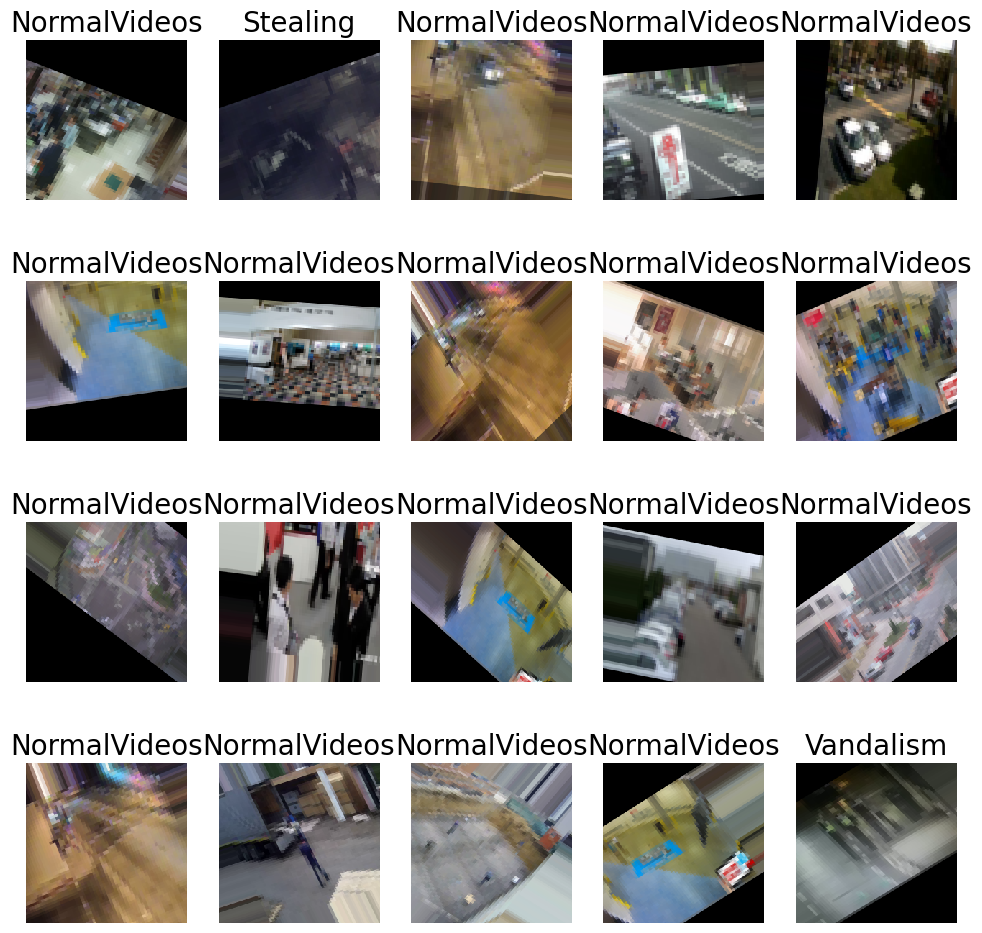

In [ ]:
plots(imgs, rows=4, titles = labelNames, maxNum=20)

In [ ]:
n = len(crime_types)

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#DenseNet121

def transfer_learning():
  base_model = DenseNet121(weights='imagenet',
                                include_top=False,
                                input_shape=(224, 224,3))
  thr=149
  for layers in base_model.layers[:thr]:
        layers.trainable=False

  for layers in base_model.layers[thr:]:
        layers.trainable=True

  return base_model

In [ ]:
def create_model():
    model=Sequential()

    base_model=transfer_learning()
    model.add(base_model)

    model.add(GlobalAveragePooling2D())

    model.add(Dense(256, activation="gelu"))
    model.add(Dropout(0.2))

    model.add(Dense(512, activation="gelu"))
    model.add(Dropout(0.2))

    model.add(Dense(1024, activation="gelu"))

    #model.add(Flatten())

    model.add(Dense(len(crime_types),activation="softmax"))

    model.summary()

    return model

In [ ]:
model=create_model()



# Display the success message.
print("Model Created Successfully!")

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0 

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)



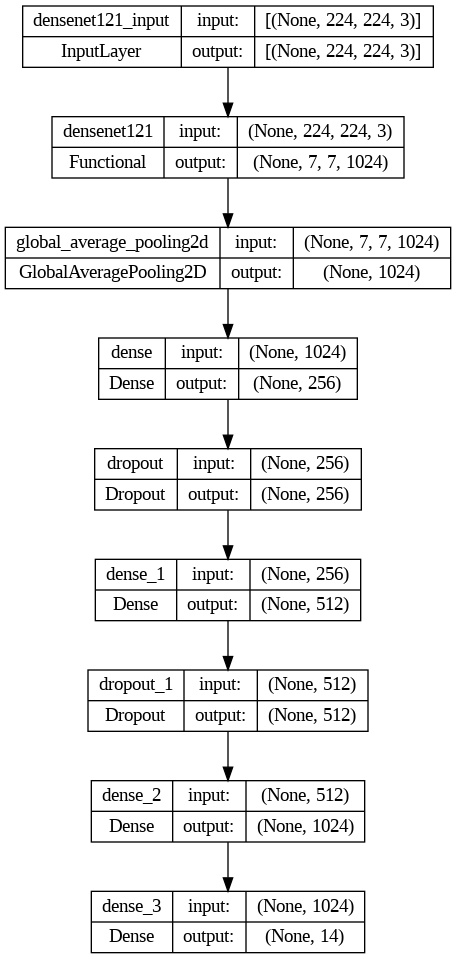

In [ ]:
# Plot the structure of the contructed model.
plot_model(model, to_file='DenseNet121(Task1+gelu)_model_structure_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(factor=0.5, patience=5, monitor='val_loss', min_lr=0.00001)
checkpoint_cb = ModelCheckpoint('model.h5', save_best_only=True)

callbacks = [earlystop_cb, reduce_lr_cb, checkpoint_cb]

In [ ]:
# Compile the model and specify loss function, optimizer and metrics to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

In [ ]:
stepsPerEpoch= (train_generator.samples+ (batchSize-1)) // batchSize
print("stepsPerEpoch: ", stepsPerEpoch)

validationSteps=(validation_generator.samples+ (batchSize-1)) // batchSize
print("validationSteps: ", validationSteps)


#validationSteps=(test_generator.samples+ (batchSize-1)) // batchSize
#print("validationSteps: ", validationSteps)

stepsPerEpoch:  4749
validationSteps:  1187


In [ ]:
train_generator.reset()
validation_generator.reset()

# Fit the model
history = model.fit_generator(
    train_generator,
    validation_data = validation_generator,
    epochs = 4,
    steps_per_epoch = stepsPerEpoch,
    validation_steps= validationSteps,
    callbacks=callbacks,
    verbose=1)

Epoch 1/4
4749/4749 [==============================] - 2983s 613ms/step - loss: 0.4848 - accuracy: 0.8643 - val_loss: 1.4800 - val_accuracy: 0.6479 - lr: 0.0010
Epoch 2/4
4749/4749 [==============================] - 2889s 608ms/step - loss: 0.2460 - accuracy: 0.9310 - val_loss: 1.6836 - val_accuracy: 0.6212 - lr: 0.0010
Epoch 3/4
4749/4749 [==============================] - 2807s 591ms/step - loss: 0.1632 - accuracy: 0.9539 - val_loss: 1.6332 - val_accuracy: 0.6544 - lr: 0.0010
Epoch 4/4
4749/4749 [==============================] - 2767s 583ms/step - loss: 0.1314 - accuracy: 0.9630 - val_loss: 1.7028 - val_accuracy: 0.6346 - lr: 0.0010


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


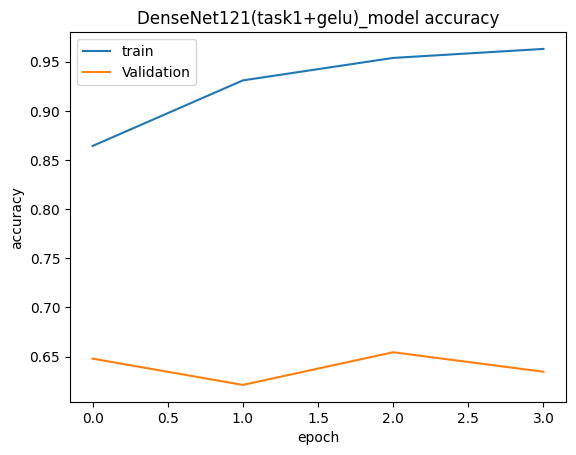

In [ ]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('DenseNet121(task1+gelu)_model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

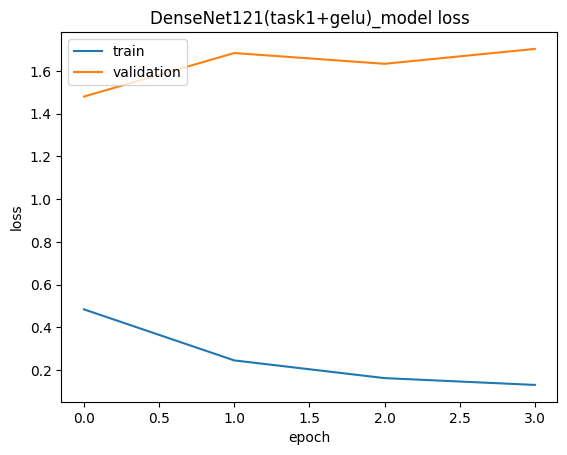

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('DenseNet121(task1+gelu)_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import time

timestr = time.strftime("%Y%m%d_%H%M%S")

# serialize model to JSON
model_json = model.to_json()
with open(timestr+"_"+"DenseNet121(task1)"+"_MODEL_3"+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(timestr+"_"+"DenseNet121(task1)"+"_3_LAST_WEIGHTS_"+".h5")

In [ ]:
# load json and create model
from keras.models import model_from_json
json_file = open('20230825_122530_DenseNet121(task1)_MODEL_3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

In [ ]:
# load weights into new model
model.load_weights("model.h5")

In [ ]:
# Compile the model and specify loss function, optimizer and metrics to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

In [ ]:
test_generator.reset()
score = model.evaluate_generator(test_generator, (test_generator.samples + (batchSize-1)) // batchSize)
print("For test data set; Loss: ",score[0]," Accuracy: ", score[1])

For test data set; Loss:  2.6079158782958984  Accuracy:  0.48513901233673096


In [ ]:
test_generator.reset()
testStep = (test_generator.samples + (batchSize-1)) // batchSize
print("testStep: ", testStep)
predictions = model.predict_generator(test_generator, steps = testStep ,  verbose = 1)
len(predictions)

testStep:  522
522/522 [==============================] - 50s 92ms/step


16688

In [ ]:
predicted_class_indices=np.argmax(predictions,axis=1)
print(predicted_class_indices)
len(predicted_class_indices)

[8 8 8 ... 7 7 7]


16688

In [ ]:
labels = (test_generator.class_indices)
print(labels)

{'Abuse': 0, 'Arrest': 1, 'Arson': 2, 'Assault': 3, 'Burglary': 4, 'Explosion': 5, 'Fighting': 6, 'NormalVideos': 7, 'RoadAccidents': 8, 'Robbery': 9, 'Shooting': 10, 'Shoplifting': 11, 'Stealing': 12, 'Vandalism': 13}


In [ ]:
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'Abuse', 1: 'Arrest', 2: 'Arson', 3: 'Assault', 4: 'Burglary', 5: 'Explosion', 6: 'Fighting', 7: 'NormalVideos', 8: 'RoadAccidents', 9: 'Robbery', 10: 'Shooting', 11: 'Shoplifting', 12: 'Stealing', 13: 'Vandalism'}


In [ ]:
predictedLables= [labels[k] for k in predicted_class_indices]
print(predictedLables)
len(predictedLables)

['RoadAccidents', 'RoadAccidents', 'RoadAccidents', 'RoadAccidents', 'RoadAccidents', 'RoadAccidents', 'RoadAccidents', 'RoadAccidents', 'RoadAccidents', 'RoadAccidents', 'RoadAccidents', 'RoadAccidents', 'RoadAccidents', 'RoadAccidents', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'RoadAccidents', 'RoadAccidents', 'RoadAccidents', 'RoadAccidents', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'Stealing', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'Arrest', 'Arrest', 'Robbery', 'Robbery', 'Robbery', 'Robbery', 'NormalVideos', 'RoadAccidents', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'NormalVideos', 'Robbery', 'Robbery', 'R

16688

In [ ]:
actualLables= [labels[k] for k in test_generator.classes]
print(actualLables)
len(actualLables)

['Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Abuse', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Arrest', 'Ar

16688

In [ ]:
# Import the necessary library
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(actualLables, predictedLables)
print(labels)
matrix

{0: 'Abuse', 1: 'Arrest', 2: 'Arson', 3: 'Assault', 4: 'Burglary', 5: 'Explosion', 6: 'Fighting', 7: 'NormalVideos', 8: 'RoadAccidents', 9: 'Robbery', 10: 'Shooting', 11: 'Shoplifting', 12: 'Stealing', 13: 'Vandalism'}


array([[   0,    0,    0,    0,    0,    0,    0,   25,   18,    0,    0,
           0,    1,    0],
       [   6,    3,   20,    0,    7,    0,    0,  386,   23,   30,    0,
           0,   27,    2],
       [   2,    0,   10,    0,    0,    6,   15,   96,    9,   50,   17,
           1,  147,   65],
       [   0,    0,    0,    0,    0,    0,    0,  289,   30,   13,    0,
          66,    0,    0],
       [   0,  193,  101,    1,    0,    4,    2,  651,    9,    2,    0,
           0,  149,   36],
       [   8,    0,   19,    0,    0,  120,    4,  429,  173,  128,    0,
           0,   73,   22],
       [   0,    0,    0,    0,    0,    1,    0,  120,    0,   44,    0,
           0,   19,    0],
       [   4, 1619,   17,    0,   44,   22,    0, 7598,  124,   71,    0,
           0,  241,    2],
       [   1,    2,    1,    0,    6,    1,   21,  255,   86,    8,    1,
           3,    8,    6],
       [   6,    0,    0,    0,    0,    0,    0,   72,    1,   22,   24,
           0,    

In [ ]:
print(classification_report(actualLables, predictedLables))

               precision    recall  f1-score   support

        Abuse       0.00      0.00      0.00        44
       Arrest       0.00      0.01      0.00       504
        Arson       0.06      0.02      0.03       418
      Assault       0.00      0.00      0.00       398
     Burglary       0.00      0.00      0.00      1148
    Explosion       0.73      0.12      0.21       976
     Fighting       0.00      0.00      0.00       184
 NormalVideos       0.66      0.78      0.72      9742
RoadAccidents       0.15      0.22      0.17       399
      Robbery       0.03      0.18      0.05       125
     Shooting       0.02      0.00      0.00      1144
  Shoplifting       0.72      0.16      0.26      1143
     Stealing       0.08      0.26      0.13       297
    Vandalism       0.00      0.00      0.00       166

     accuracy                           0.49     16688
    macro avg       0.18      0.12      0.11     16688
 weighted avg       0.49      0.49      0.46     16688



In [ ]:
# Import the necessary library
from sklearn.metrics import recall_score

recall_score( actualLables, predictedLables,average='weighted')

0.4851390220517737

In [ ]:
from sklearn.metrics import precision_score
precision_score( actualLables, predictedLables,average='weighted')

0.48737266711062227

DenseNet121(Task1)_Confusion matrix, without normalization
[[   0    0    0    0    0    0    0   25   18    0    0    0    1    0]
 [   6    3   20    0    7    0    0  386   23   30    0    0   27    2]
 [   2    0   10    0    0    6   15   96    9   50   17    1  147   65]
 [   0    0    0    0    0    0    0  289   30   13    0   66    0    0]
 [   0  193  101    1    0    4    2  651    9    2    0    0  149   36]
 [   8    0   19    0    0  120    4  429  173  128    0    0   73   22]
 [   0    0    0    0    0    1    0  120    0   44    0    0   19    0]
 [   4 1619   17    0   44   22    0 7598  124   71    0    0  241    2]
 [   1    2    1    0    6    1   21  255   86    8    1    3    8    6]
 [   6    0    0    0    0    0    0   72    1   22   24    0    0    0]
 [  40   58    3    0    2    1   40  844   31   38    1    0   69   17]
 [  22    0    0    0    8   10   69  423   73  333    0  180   25    0]
 [   0    1    1    0    2    0    0  183    2    1    0    0   7

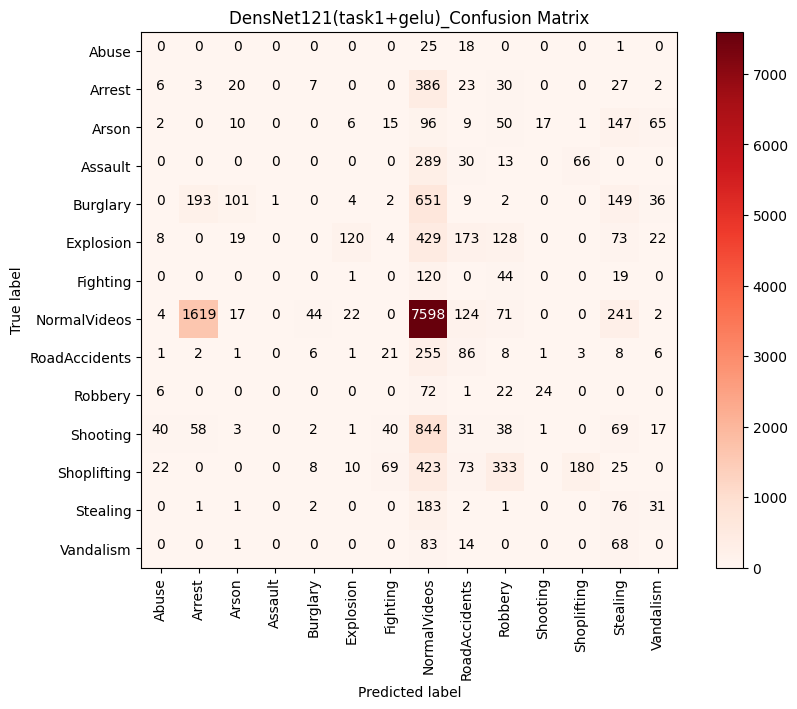

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds,
                          figsize=(10, 8)):  # Change the figsize here
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('DenseNet121(Task1)_Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=figsize)  # Set the figure size here
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Import the itertools module
import itertools
cm_plot_labels = crime_types
plot_confusion_matrix(matrix, cm_plot_labels, normalize=False, title='DensNet121(task1+gelu)_Confusion Matrix', figsize=(9, 7))
